# Make an AnnData using OTG and GWAS catalog datasets

In [1]:
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import gc
import json
import numpy as np
import scipy as sp
import scipy.sparse as spp
import scanpy as sc
from pandas.io.json import json_normalize

In [2]:
pd.set_option('display.max_columns', None)

## Read OTG and GWAS catalog datasets

In [3]:
otg = pd.read_pickle('data/info.pkl').reset_index()
otg = otg[otg.studyId != 'GCST006585'].copy() ## exclude protein levels
otg['uniq_index'] = otg.studyId.astype(str) + '_' + otg.traitReported.astype(str)

gwas_cat = pd.read_pickle('data/gwas_catalog_nov_11_2020_nonOTG_traits.pkl').reset_index()
gwas_cat['uniq_index'] = gwas_cat['STUDY ACCESSION'].astype(str) + '_' + gwas_cat['DISEASE/TRAIT'].astype(str) + '_' + gwas_cat['MAPPED_TRAIT'].astype(str)

In [4]:
otg.head()

,studyId,traitReported,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumsStats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,nTotal,traitCategory,numAssocLoci,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,uniq_index
0,GCST000001,Age-related macular degeneration,[EFO_0001365],PMID:15761122,2005-03-10,Science,Complement factor H polymorphism in age-relate...,Klein RJ,False,[European=146],[],146,NaN,96,146,Nervous system,1,"(ENSG00000000971,)","(CFH,)",GCST000001_Age-related macular degeneration
1,GCST000002,Parkinson's disease,[EFO_0002508],PMID:16252231,2005-09-09,Am J Hum Genet,High-resolution whole-genome association study...,Maraganore DM,False,"[Asian unspecified=1, European=744, Other=141]","[Other=122, Asian unspecified=1, European=541]",886,664,NaN,1550,Nervous system,0,NaN,NaN,GCST000002_Parkinson's disease
2,GCST000003,Obesity,[EFO_0001073],PMID:16614226,2006-04-14,Science,A common genetic variant is associated with ad...,Herbert A,False,[NR=694],"[European=10527, African American or Afro-Cari...",694,11622,NaN,12316,Disease,0,NaN,NaN,GCST000003_Obesity
3,GCST000004,QT interval,[EFO_0004682],PMID:16648850,2006-04-30,Nat Genet,A common genetic variant in the NOS1 regulator...,Arking DE,False,[European=200],[European=4851],200,4851,NaN,5051,Cardiovascular measurement,1,"(ENSG00000198929,)","(NOS1AP,)",GCST000004_QT interval
4,GCST000005,Parkinson's disease,[EFO_0002508],PMID:17052657,2006-09-28,Lancet Neurol,Genome-wide genotyping in Parkinson's disease ...,Fung HC,False,[European=537],[],537,NaN,267,537,Nervous system,0,NaN,NaN,GCST000005_Parkinson's disease


## OTG and GWAS catalog process studies with multiple traits differently

In [6]:
df = otg[['traitReported', 'pmid', 'studyId', 'uniq_index']].drop_duplicates()
df[df.pmid.duplicated(keep=False)].head(10)

,traitReported,pmid,studyId,uniq_index
18,Prostate cancer,PMID:17401366,GCST000019,GCST000019_Prostate cancer
19,Prostate cancer [EA],PMID:17401366,GCST000019_2,GCST000019_2_Prostate cancer [EA]
24,Type 2 diabetes,PMID:17463248,GCST000024,GCST000024_Type 2 diabetes
25,Type 2 diabetes [DGI+FUSION+WTCCC],PMID:17463248,GCST000024_2,GCST000024_2_Type 2 diabetes [DGI+FUSION+WTCCC]
26,Type 2 diabetes,PMID:17463249,GCST000025,GCST000025_Type 2 diabetes
27,Type 2 diabetes [DGI+FUSION+WTCCC],PMID:17463249,GCST000025_2,GCST000025_2_Type 2 diabetes [DGI+FUSION+WTCCC]
28,Triglycerides,PMID:17463246,GCST000026,GCST000026_Triglycerides
30,Type 2 diabetes,PMID:17463246,GCST000028,GCST000028_Type 2 diabetes
42,Rheumatoid arthritis,PMID:17554300,GCST000040,GCST000040_Rheumatoid arthritis
43,Rheumatoid arthritis [sex-differentiated],PMID:17554300,GCST000040_2,GCST000040_2_Rheumatoid arthritis [sex-differe...


In [7]:
df = gwas_cat[['DISEASE/TRAIT', 'MAPPED_TRAIT', 'PUBMEDID', 'uniq_index', 'STUDY ACCESSION']].drop_duplicates()
df[df['STUDY ACCESSION'].duplicated(keep=False)].head(30)

,DISEASE/TRAIT,MAPPED_TRAIT,PUBMEDID,uniq_index,STUDY ACCESSION
109,Metabolite levels,Acylcarnitine measurement,31628463,GCST009698_Metabolite levels_Acylcarnitine mea...,GCST009698
110,Metabolite levels,Ceramide measurement,31628463,GCST009698_Metabolite levels_Ceramide measurement,GCST009698
111,Metabolite levels,Glycine measurement,31628463,GCST009698_Metabolite levels_Glycine measurement,GCST009698
112,Metabolite levels,Proline measurement,31628463,GCST009698_Metabolite levels_Proline measurement,GCST009698
113,Metabolite levels,Serine measurement,31628463,GCST009698_Metabolite levels_Serine measurement,GCST009698
114,Metabolite levels,Sphingolipid measurement,31628463,GCST009698_Metabolite levels_Sphingolipid meas...,GCST009698
115,Metabolite levels,Sphingomyelin measurement,31628463,GCST009698_Metabolite levels_Sphingomyelin mea...,GCST009698
203,Salivary metabolite levels,"Salivary metabolite measurement, dimethylglyci...",31960908,GCST009885_Salivary metabolite levels_Salivary...,GCST009885
204,Salivary metabolite levels,"Salivary metabolite measurement, urate measure...",31960908,GCST009885_Salivary metabolite levels_Salivary...,GCST009885
208,Serum metabolite levels,"Carnitine measurement, serum metabolite measur...",25569235,GCST009893_Serum metabolite levels_Carnitine m...,GCST009893


In [8]:
gwas_cat.head()

,STUDY ACCESSION,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,MAPPED_TRAIT,INITIAL SAMPLE SIZE,ASSOCIATION COUNT,rsid,otg_variant_id,otg_v2g_gene_id,otg_v2g_gene_symbol,INITIAL_SAMPLE_SIZE_INT,ASSOCIATION COUNT MAPPED TRAIT,uniq_index
0,GCST000115,2009-02-16,17952075,Sulem P,2007-10-21,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/17952075,"Genetic determinants of hair, eye and skin pig...",Red vs non-red hair color,Hair color,"2,986 individuals",1,"(rs1805007, rs1805007, rs1805007, rs1805007, r...","(16_89919709_C_T, 16_89919709_C_T, 16_89919709...","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,GCST000115_Red vs non-red hair color_Hair color
1,GCST000116,2009-02-16,17952075,Sulem P,2007-10-21,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/17952075,"Genetic determinants of hair, eye and skin pig...",Skin sensitivity to sun,Skin sensitivity to sun,"2,986 individuals",2,"(rs1805007, rs1805007, rs1805007, rs1805007, r...","(16_89919709_C_T, 16_89919709_C_T, 16_89919709...","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,GCST000116_Skin sensitivity to sun_Skin sensit...
2,GCST000117,2008-06-16,17952075,Sulem P,2007-10-21,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/17952075,"Genetic determinants of hair, eye and skin pig...",Blue vs. green eyes,Eye color,"2,986 individuals",3,"(rs1667394,)","(15_28285036_C_T,)","(ENSG00000128731,)","(HERC2,)",2986,1,GCST000117_Blue vs. green eyes_Eye color
3,GCST000119,2008-06-16,17952075,Sulem P,2007-10-21,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/17952075,"Genetic determinants of hair, eye and skin pig...",Freckles,Freckles,"2,986 individuals",3,"(rs1805007, rs1805007, rs1805007, rs1805007, r...","(16_89919709_C_T, 16_89919709_C_T, 16_89919709...","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1, TYR)",2986,6,GCST000119_Freckles_Freckles
4,GCST000120,2009-02-16,17952075,Sulem P,2007-10-21,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/17952075,"Genetic determinants of hair, eye and skin pig...",Blue vs. brown eyes,Eye color,"2,986 individuals",1,"(rs1667394,)","(15_28285036_C_T,)","(ENSG00000128731,)","(HERC2,)",2986,1,GCST000120_Blue vs. brown eyes_Eye color


In [9]:
otg = otg.rename(columns={'bestLocus2GenesOrClosest_id': 'gene_id', 'bestLocus2GenesOrClosest_symbol': 'gene_symbol'})

In [10]:
gwas_cat = gwas_cat.rename(columns={
    'STUDY ACCESSION': 'studyId',
    'DATE': 'pubDate',
    'PUBMEDID': 'pmid',
    'FIRST AUTHOR': 'pubAuthor',
    'JOURNAL': 'pubJournal',
    'INITIAL SAMPLE SIZE': 'ancestryInitial',
    'INITIAL_SAMPLE_SIZE_INT': 'nInitial',
    'STUDY': 'pubTitle',
    'MAPPED_TRAIT': 'traitReported',
    'ASSOCIATION COUNT MAPPED TRAIT': 'numAssocLoci',
    'otg_v2g_gene_id': 'gene_id',
    'otg_v2g_gene_symbol': 'gene_symbol'
}).drop(columns=['DATE ADDED TO CATALOG', 'LINK', 'rsid', 'otg_variant_id', 'DISEASE/TRAIT', 'ASSOCIATION COUNT']).set_index('studyId')

gwas_cat

,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,uniq_index
studyId,,,,,,,,,,,,
GCST000115,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Hair color,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,GCST000115_Red vs non-red hair color_Hair color
GCST000116,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Skin sensitivity to sun,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,GCST000116_Skin sensitivity to sun_Skin sensit...
GCST000117,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Eye color,"2,986 individuals","(ENSG00000128731,)","(HERC2,)",2986,1,GCST000117_Blue vs. green eyes_Eye color
GCST000119,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Freckles,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1, TYR)",2986,6,GCST000119_Freckles_Freckles
GCST000120,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Eye color,"2,986 individuals","(ENSG00000128731,)","(HERC2,)",2986,1,GCST000120_Blue vs. brown eyes_Eye color
...,...,...,...,...,...,...,...,...,...,...,...,...
GCST90010361,31566214,Kulminski AM,2019-09-30,J Gerontol A Biol Sci Med Sci,Quantitative and qualitative role of antagonis...,High density lipoprotein cholesterol measurement,"29,902 European ancestry individuals","(ENSG00000072736, ENSG00000141096, ENSG0000016...","(NFATC3, DPEP3, DUS2, LCAT, DPEP2, GFOD2, ACD,...",29902,21,GCST90010361_High density lipoprotein choleste...
GCST90010362,31566214,Kulminski AM,2019-09-30,J Gerontol A Biol Sci Med Sci,Quantitative and qualitative role of antagonis...,Triglyceride measurement,"29,902 European ancestry individuals","(ENSG00000162607, ENSG00000116641, ENSG0000000...","(USP1, DOCK7, MLXIPL, GRB14, COBLL1, NRBF2, RE...",29902,23,GCST90010362_Triglyceride levels_Triglyceride ...
GCST90010363,31566214,Kulminski AM,2019-09-30,J Gerontol A Biol Sci Med Sci,Quantitative and qualitative role of antagonis...,Total cholesterol measurement,"29,902 European ancestry individuals","(ENSG00000179344, ENSG00000198502, ENSG0000020...","(HLA-DQB1, HLA-DRB5, MICB, HLA-DQA1, HLA-DRB1,...",29902,31,GCST90010363_Total cholesterol levels_Total ch...


In [12]:
gwas_cat.loc[['GCST009698']]

,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,uniq_index
studyId,,,,,,,,,,,,
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Acylcarnitine measurement,"1,954 Chinese ancestry individuals","(ENSG00000134538, ENSG00000171503, ENSG0000012...","(SLCO1B1, ETFDH, MYRF, FADS2, TMEM258, FADS1, ...",1954,12,GCST009698_Metabolite levels_Acylcarnitine mea...
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Ceramide measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296, ENSG00000157895, ENSG0000013...","(SPTLC3, C12orf43, OASL, HNF1A, CCNG1, SLCO1B3...",1954,23,GCST009698_Metabolite levels_Ceramide measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Glycine measurement,"1,954 Chinese ancestry individuals","(ENSG00000021826,)","(CPS1,)",1954,1,GCST009698_Metabolite levels_Glycine measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Proline measurement,"1,954 Chinese ancestry individuals","(ENSG00000183628, ENSG00000100033)","(DGCR6, PRODH)",1954,2,GCST009698_Metabolite levels_Proline measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Serine measurement,"1,954 Chinese ancestry individuals","(ENSG00000106153,)","(CHCHD2,)",1954,1,GCST009698_Metabolite levels_Serine measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Sphingolipid measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296, ENSG00000204388, ENSG0000005...","(SPTLC3, HSPA1B, SYNE2, ABCA7, POLR2E, SLCO5A1...",1954,14,GCST009698_Metabolite levels_Sphingolipid meas...
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Sphingomyelin measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296,)","(SPTLC3,)",1954,5,GCST009698_Metabolite levels_Sphingomyelin mea...


In [13]:
gwas_cat[gwas_cat.pubTitle.str.contains('Covid')]

,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,uniq_index
studyId,,,,,,,,,,,,
GCST90000255,32558485,Ellinghaus D,2020-06-17,N Engl J Med,Genomewide Association Study of Severe Covid-1...,COVID-19,"1,610 European ancestry cases, 2,205 European ...","(ENSG00000175164,)","(ABO,)",3815,1,GCST90000255_Severe COVID-19 infection with re...
unpublished_2020_09_25_medrxiv,unpublished,Pairo-Castineira E,2020-09-25,medrxiv,Genetic mechanisms of critical illness in Covi...,COVID-19,"2,636 GenOMICC 134 ISARIC 4C 10,000 controls","(ENSG00000172215, ENSG00000204632, ENSG0000020...","(CXCR6, HLA-G, HLA-F, HLA-A, ZFP57, MICA, HLA-...",12770,40,unpublished_2020_09_25_medrxiv_COVID-19_COVID-19


In [14]:
gwas = pd.concat([gwas_cat.assign(source='gwascat'), otg.set_index('studyId').assign(source='otg')], axis=0).reset_index().set_index('uniq_index')
gwas = gwas[~gwas.gene_symbol.isnull()]
gwas.head(20)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory
uniq_index,,,,,,,,,,,,,,,,,,,,
GCST000115_Red vs non-red hair color_Hair color,GCST000115,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Hair color,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000116_Skin sensitivity to sun_Skin sensitivity to sun,GCST000116,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Skin sensitivity to sun,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1)",2986,5,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000117_Blue vs. green eyes_Eye color,GCST000117,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Eye color,"2,986 individuals","(ENSG00000128731,)","(HERC2,)",2986,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000119_Freckles_Freckles,GCST000119,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Freckles,"2,986 individuals","(ENSG00000204991, ENSG00000141013, ENSG0000025...","(SPIRE2, GAS8, MC1R, DBNDD1, AC092143.1, TYR)",2986,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000120_Blue vs. brown eyes_Eye color,GCST000120,17952075,Sulem P,2007-10-21,Nat Genet,"Genetic determinants of hair, eye and skin pig...",Eye color,"2,986 individuals","(ENSG00000128731,)","(HERC2,)",2986,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST009420_Retinal arteriolar tortuosity_Retinal vasculature measurement,GCST009420,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Retinal vasculature measurement,"3,094 European ancestry individuals","(ENSG00000134871,)","(COL4A2,)",3094,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST009422_Retinal venular tortuosity_Retinal vasculature measurement,GCST009422,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Retinal vasculature measurement,"3,094 European ancestry individuals","(ENSG00000182472, ENSG00000130402)","(CAPN12, ACTN4)",3094,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Optic disc measurement,"3,094 European ancestry individuals","(ENSG00000108187, ENSG00000179774, ENSG0000012...","(PBLD, ATOH7, SLC25A16, DNA2)",3094,7,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST009429_Age-related hearing impairment (high frequency)_Age-related hearing impairment,GCST009429,31645637,Nagtegaal AP,2019-10-23,Sci Rep,Genome-wide association meta-analysis identifi...,Age-related hearing impairment,"9,675 European ancestry individuals","(ENSG00000159588, ENSG00000086015, ENSG0000019...","(CCDC17, MAST2, IPP, GPBP1L1, EAF2, SLC15A2, C...",9675,29,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
gwas[gwas.studyId == 'GCST90000255']

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory
uniq_index,,,,,,,,,,,,,,,,,,,,
GCST90000255_Severe COVID-19 infection with respiratory failure (analysis I)_COVID-19,GCST90000255,32558485,Ellinghaus D,2020-06-17,N Engl J Med,Genomewide Association Study of Severe Covid-1...,COVID-19,"1,610 European ancestry cases, 2,205 European ...","(ENSG00000175164,)","(ABO,)",3815,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filter by numAssocLoci and nInitial

In [16]:
gwas = gwas[(gwas.numAssocLoci >= 2) & (gwas.nInitial > 3000)]
gwas.shape

(5538, 20)

In [17]:
pd.options.display.max_rows = 50
pd.options.display.min_rows = 10

In [18]:
gwas['traitEfosStr'] = gwas.traitEfos.fillna('').astype(str)

## Take the study with the max nInitial for each trait group

In [19]:
#info = info[info.traitEfosStr != '[]']
#idx = info.groupby(['traitEfosStr'])['nInitial'].transform(max) == info['nInitial']
#info = info[idx]
#info.shape

In [20]:
pd.options.display.min_rows = 10
gwas.sort_values('nInitial', ascending=False)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,
GCST007341_Well-being spectrum (multivariate analysis),GCST007341,PMID:30643256,Baselmans BML,2019-01-14,Nat Genet,Multivariate genome-wide analyses of the well-...,Well-being spectrum (multivariate analysis),[European=2083151],"(ENSG00000162426, ENSG00000127483, ENSG0000011...","(SLC45A1, HP1BP3, CSF3R, GRIK3, TAL1, NEGR1, L...",2083151,231,otg,[EFO_0007869],False,[European=287239],287239,NaN,2370390.0,Mental or behavioural disorder biomarker,['EFO_0007869']
GCST010557_Type 2 diabetes_Type II diabetes mellitus,GCST010557,32541925,Vujkovic M,2020-06-15,Nat Genet,Discovery of 318 new risk loci for type 2 diab...,Type II diabetes mellitus,"148,726 European ancestry cases, 24,646 Africa...","(ENSG00000143363, ENSG00000163141, ENSG0000010...","(PRUNE1, BNIPL, IFT52, MYBL2, QSER1, SH2B1, SG...",1407282,611,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST007468_Smoking initiation (ever regular vs never regular) (MTAG),GCST007468,PMID:30643251,Liu M,2019-01-14,Nat Genet,Association studies of up to 1.2 million indiv...,Smoking initiation (ever regular vs never regu...,[European=1359002],"(ENSG00000049245, ENSG00000162426, ENSG0000011...","(VAMP3, SLC45A1, IGSF21, EIF4G3, COL16A1, A3GA...",1359002,647,otg,[EFO_0006527],False,[],None,None,1359002.0,Smoking behaviour measurement,['EFO_0006527']
GCST007988_Insomnia,GCST007988,PMID:30804565,Jansen PR,2019-02-25,Nat Genet,"Genome-wide analysis of insomnia in 1,331,010 ...",Insomnia,[European=1331010],"(ENSG00000119535, ENSG00000021852, ENSG0000018...","(CSF3R, C8B, PDE4B, NEGR1, LRRIQ3, TNNI3K, PTB...",1331010,254,otg,[EFO_0007876],False,[],None,NaN,1331010.0,Sleep measurement,['EFO_0007876']
GCST007988_2_Insomnia [Female],GCST007988_2,PMID:30804565,Jansen PR,2019-02-25,Nat Genet,"Genome-wide analysis of insomnia in 1,331,010 ...",Insomnia [Female],[European=1331010],"(ENSG00000172260, ENSG00000162670, ENSG0000005...","(NEGR1, BRINP3, MTA3, LRPPRC, NRXN1, MEIS1, PA...",1331010,90,otg,[EFO_0007876],False,[],None,NaN,1331010.0,Sleep measurement,['EFO_0007876']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCST002758_Oligoclonal band status in multiple sclerosis,GCST002758,PMID:25616667,Goris A,2015-01-22,Brain,Genetic variants are major determinants of CSF...,Oligoclonal band status in multiple sclerosis,"[NR=519, European=2507]","(ENSG00000204287, ENSG00000196735, ENSG0000023...","(HLA-DRA, HLA-DQA1, HLA-DQA2)",3026,3,otg,"[EFO_0003885, EFO_0005206]",False,"[N, European=3478]",3478,NaN,6504.0,Immune system,"['EFO_0003885', 'EFO_0005206']"
GCST000814_5_Red blood cell traits [RBC count],GCST000814_5,PMID:20927387,Kullo IJ,2010-09-28,PLoS One,A genome-wide association study of red blood c...,Red blood cell traits [RBC count],[European=3012],"(ENSG00000112339, ENSG00000118513)","(HBS1L, MYB)",3012,2,otg,[EFO_0004305],False,[],NaN,NaN,3012.0,Hematological measurement,['EFO_0004305']
GCST000814_4_Red blood cell traits [MCV],GCST000814_4,PMID:20927387,Kullo IJ,2010-09-28,PLoS One,A genome-wide association study of red blood c...,Red blood cell traits [MCV],[European=3012],"(ENSG00000112339, ENSG00000118513, ENSG0000018...","(HBS1L, MYB, TMPRSS6)",3012,3,otg,[EFO_0004526],False,[],NaN,NaN,3012.0,Hematological measurement,['EFO_0004526']


## Remove "None of the above" traits

In [21]:
gwas = gwas[~gwas.traitReported.str.contains('above')]
gwas.head(10)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,
GCST009422_Retinal venular tortuosity_Retinal vasculature measurement,GCST009422,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Retinal vasculature measurement,"3,094 European ancestry individuals","(ENSG00000182472, ENSG00000130402)","(CAPN12, ACTN4)",3094,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Optic disc measurement,"3,094 European ancestry individuals","(ENSG00000108187, ENSG00000179774, ENSG0000012...","(PBLD, ATOH7, SLC25A16, DNA2)",3094,7,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009429_Age-related hearing impairment (high frequency)_Age-related hearing impairment,GCST009429,31645637,Nagtegaal AP,2019-10-23,Sci Rep,Genome-wide association meta-analysis identifi...,Age-related hearing impairment,"9,675 European ancestry individuals","(ENSG00000159588, ENSG00000086015, ENSG0000019...","(CCDC17, MAST2, IPP, GPBP1L1, EAF2, SLC15A2, C...",9675,29,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009432_Age-related hearing impairment (low/mid frequency)_Age-related hearing impairment,GCST009432,31645637,Nagtegaal AP,2019-10-23,Sci Rep,Genome-wide association meta-analysis identifi...,Age-related hearing impairment,"9,675 European ancestry individuals","(ENSG00000221946, ENSG00000089327)","(FXYD7, FXYD5)",9675,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009437_Birth weight_Birth weight,GCST009437,31097437,Plotnikov D,2019-05-16,Br J Ophthalmol,Association between birth weight and refractiv...,Birth weight,"188,039 European ancestry individuals","(ENSG00000241399, ENSG00000123636, ENSG0000016...","(CD302, BAZ2B, DCAF16, CPA3, ANK1, ADAM15, DCS...",188039,86,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009447_Parental longevity (father's age at death)_Parental longevity,GCST009447,31484785,Wright KM,2019-09-04,G3 (Bethesda),A Prospective Analysis of Genetic Variants Ass...,Parental longevity,"309,383 European ancestry individuals","(ENSG00000146701, ENSG00000127948, ENSG0000018...","(MDH2, POR, TMEM120A, RHBDD2, STYXL1, IREB2, C...",309383,10,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009448_Longevity_Longevity,GCST009448,31484785,Wright KM,2019-09-04,G3 (Bethesda),A Prospective Analysis of Genetic Variants Ass...,Longevity,"up to 482,000 European ancestry individuals","(ENSG00000152061, ENSG00000117601, ENSG0000013...","(RABGAP1L, SERPINC1, RC3H1, HSD17B12, GPR52, N...",482000,9,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009449_Parental longevity (mother's age at death or mother's attained age)_Parental longevity,GCST009449,31484785,Wright KM,2019-09-04,G3 (Bethesda),A Prospective Analysis of Genetic Variants Ass...,Parental longevity,"up to 699,000 individuals","(ENSG00000130203, ENSG00000136381, ENSG0000004...","(APOE, IREB2, PSMA4, CHRNA5, GMPPB, APEH, INKA...",699000,11,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009450_Parental longevity (father's age at death or father's attained age)_Parental longevity,GCST009450,31484785,Wright KM,2019-09-04,G3 (Bethesda),A Prospective Analysis of Genetic Variants Ass...,Parental longevity,"up to 699,000 European ancestry individuals","(ENSG00000198563, ENSG00000204516, ENSG0000023...","(DDX39B, MICB, HLA-B, SORT1, PSRC1, CELSR2, KI...",699000,16,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [22]:
gwas = gwas[~gwas.index.duplicated()].copy()

<AxesSubplot:>

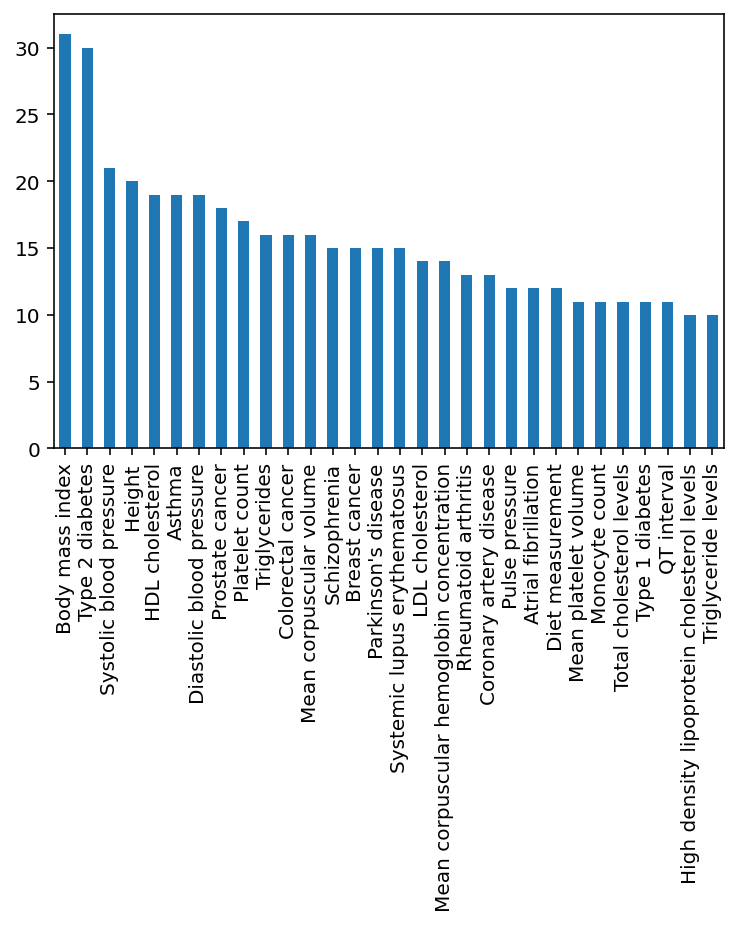

In [23]:
pd.options.display.min_rows = 10
pd.options.display.max_rows = 100
gwas.traitReported.value_counts()[:30].plot(kind='bar')

## Make a study-trait by gene matrix

In [24]:
assert np.all(gwas.explode('gene_id').index == gwas.explode('gene_symbol').index)
assert np.all(gwas.explode('gene_id').studyId == gwas.explode('gene_symbol').studyId)

In [25]:
gwas[gwas.index.duplicated()]

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,


In [26]:
gwas_e = gwas.explode('gene_id').assign(gene_symbol=gwas.explode('gene_symbol').gene_symbol)

In [27]:
gwas_e

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,
GCST009422_Retinal venular tortuosity_Retinal vasculature measurement,GCST009422,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Retinal vasculature measurement,"3,094 European ancestry individuals",ENSG00000182472,CAPN12,3094,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009422_Retinal venular tortuosity_Retinal vasculature measurement,GCST009422,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Retinal vasculature measurement,"3,094 European ancestry individuals",ENSG00000130402,ACTN4,3094,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Optic disc measurement,"3,094 European ancestry individuals",ENSG00000108187,PBLD,3094,7,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Optic disc measurement,"3,094 European ancestry individuals",ENSG00000179774,ATOH7,3094,7,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,Novel Genetic Locus Influencing Retinal Venula...,Optic disc measurement,"3,094 European ancestry individuals",ENSG00000122912,SLC25A16,3094,7,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_803_2_Fracture of radius and ulna,SAIGE_803_2,None,UKB SAIGE,2018-10-24,None,None,Fracture of radius and ulna,[European=393011],ENSG00000002745,WNT16,393011,3,otg,[EFO_0003931],True,[],0,5246,393011.0,Musculoskeletal system,['EFO_0003931']
SAIGE_804_Fracture of hand or wrist,SAIGE_804,None,UKB SAIGE,2018-10-24,None,None,Fracture of hand or wrist,[European=391122],ENSG00000002745,WNT16,391122,2,otg,[EFO_0009515],True,[],0,3357,391122.0,Musculoskeletal system,['EFO_0009515']
SAIGE_804_Fracture of hand or wrist,SAIGE_804,None,UKB SAIGE,2018-10-24,None,None,Fracture of hand or wrist,[European=391122],ENSG00000101654,RNMT,391122,2,otg,[EFO_0009515],True,[],0,3357,391122.0,Musculoskeletal system,['EFO_0009515']


In [29]:
df = gwas_e[['gene_symbol', 'gene_id']].drop_duplicates().reset_index(drop=True)
df = df[df.gene_symbol.duplicated(keep=False)].sort_values('gene_symbol')
df

,gene_symbol,gene_id
3704,AHRR,ENSG00000063438
12371,AHRR,ENSG00000286169
7654,ATF7,ENSG00000170653
11596,ATF7,ENSG00000267281
4769,ATXN7,ENSG00000163635
10354,ATXN7,ENSG00000285258
56,IGF2,ENSG00000167244
7592,IGF2,ENSG00000284779
6716,PINX1,ENSG00000258724
6888,PINX1,ENSG00000254093


In [30]:
import gprofiler

g = gprofiler.GProfiler()
df.merge(pd.DataFrame(g.convert(df.gene_id.tolist())), left_on='gene_id', right_on='incoming', how='left')

,gene_symbol,gene_id,converted,description,incoming,n_converted,n_incoming,name,namespaces,query
0,AHRR,ENSG00000063438,ENSG00000063438,aryl-hydrocarbon receptor repressor [Source:HG...,ENSG00000063438,1,1,AHRR,"ARRAYEXPRESS,ENSG",query_1
1,AHRR,ENSG00000286169,ENSG00000286169,PDCD6-AHRR readthrough (NMD candidate) [Source...,ENSG00000286169,1,2,PDCD6-AHRR,"ARRAYEXPRESS,ENSG",query_1
2,ATF7,ENSG00000170653,ENSG00000170653,activating transcription factor 7 [Source:HGNC...,ENSG00000170653,1,3,ATF7,"ARRAYEXPRESS,ENSG",query_1
3,ATF7,ENSG00000267281,ENSG00000267281,ATF7-NPFF readthrough [Source:NCBI gene (forme...,ENSG00000267281,1,4,ATF7-NPFF,"ARRAYEXPRESS,ENSG",query_1
4,ATXN7,ENSG00000163635,ENSG00000163635,ataxin 7 [Source:HGNC Symbol;Acc:HGNC:10560],ENSG00000163635,1,5,ATXN7,"ARRAYEXPRESS,ENSG",query_1
5,ATXN7,ENSG00000285258,None,None,ENSG00000285258,1,6,None,,query_1
6,IGF2,ENSG00000167244,ENSG00000167244,insulin like growth factor 2 [Source:HGNC Symb...,ENSG00000167244,1,7,IGF2,"ARRAYEXPRESS,ENSG",query_1
7,IGF2,ENSG00000284779,ENSG00000284779,novel protein,ENSG00000284779,1,8,AC132217.2,"ARRAYEXPRESS,ENSG",query_1
8,PINX1,ENSG00000258724,ENSG00000258724,PIN2 (TERF1) interacting telomerase inhibitor ...,ENSG00000258724,1,9,PINX1,"ARRAYEXPRESS,ENSG",query_1
9,PINX1,ENSG00000254093,ENSG00000254093,PIN2 (TERF1) interacting telomerase inhibitor ...,ENSG00000254093,1,10,PINX1,"ARRAYEXPRESS,ENSG",query_1


In [31]:
gwas.index.nunique()

5515

In [32]:
gwas.shape

(5515, 21)

In [33]:
gwas.loc[gwas.index.duplicated(keep=False)]

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,nInitial,numAssocLoci,source,traitEfos,hasSumsStats,ancestryReplication,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,


In [36]:
pd.set_option('display.max_columns', 10)

In [37]:
'nan' in gwas_e.gene_id.unique()

False

In [38]:
studytrait_by_gene = gwas_e.reset_index().assign(value=1).pivot(values='value', index='uniq_index', columns='gene_id').fillna(0).astype(int)
studytrait_by_gene

gene_id,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001084,...,ENSG00000286143,ENSG00000286169,ENSG00000286231,ENSG00000286239,ENSG00000286264
uniq_index,,,,,,,,,,,
GCST000025_2_Type 2 diabetes [DGI+FUSION+WTCCC],0,0,0,0,0,...,0,0,0,0,0
GCST000025_Type 2 diabetes,0,0,0,0,0,...,0,0,0,0,0
GCST000027_Type 2 diabetes,0,0,0,0,0,...,0,0,0,0,0
GCST000037_Breast cancer,0,0,0,0,0,...,0,0,0,0,0
GCST000038_Type 1 diabetes,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_803_2_Fracture of radius and ulna,0,0,0,0,0,...,0,0,0,0,0
SAIGE_803_Fracture of upper limb,0,0,0,0,0,...,0,0,0,0,0
SAIGE_804_Fracture of hand or wrist,0,0,0,0,0,...,0,0,0,0,0


<AxesSubplot:>

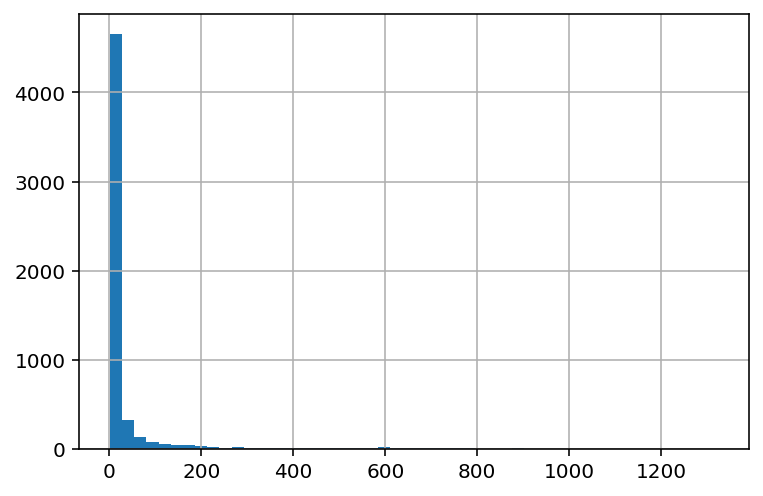

In [39]:
studytrait_by_gene.sum(1).hist(bins=50)

In [40]:
#studytrait_by_gene = studybygene[(studybygene.sum(1)>=2) & (studybygene.sum(1)<=850)]
#studytrait_by_gene.shape

## Make an anndata

In [41]:
gwas.head()

,studyId,pmid,pubAuthor,pubDate,pubJournal,...,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,
GCST009422_Retinal venular tortuosity_Retinal vasculature measurement,GCST009422,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,...,NaN,NaN,NaN,NaN,
GCST009427_Optic disc radius_Optic disc measurement,GCST009427,31597446,Veluchamy A,2019-10-10,Arterioscler Thromb Vasc Biol,...,NaN,NaN,NaN,NaN,
GCST009429_Age-related hearing impairment (high frequency)_Age-related hearing impairment,GCST009429,31645637,Nagtegaal AP,2019-10-23,Sci Rep,...,NaN,NaN,NaN,NaN,
GCST009432_Age-related hearing impairment (low/mid frequency)_Age-related hearing impairment,GCST009432,31645637,Nagtegaal AP,2019-10-23,Sci Rep,...,NaN,NaN,NaN,NaN,
GCST009437_Birth weight_Birth weight,GCST009437,31097437,Plotnikov D,2019-05-16,Br J Ophthalmol,...,NaN,NaN,NaN,NaN,


In [42]:
adata = sc.AnnData(studytrait_by_gene, obs=gwas.loc[~gwas.index.duplicated()].loc[studytrait_by_gene.index]) #, var=gene_table.loc[studybygene.columns])
adata.X = spp.csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 5515 × 13062
    obs: 'studyId', 'pmid', 'pubAuthor', 'pubDate', 'pubJournal', 'pubTitle', 'traitReported', 'ancestryInitial', 'gene_id', 'gene_symbol', 'nInitial', 'numAssocLoci', 'source', 'traitEfos', 'hasSumsStats', 'ancestryReplication', 'nReplication', 'nCases', 'nTotal', 'traitCategory', 'traitEfosStr'

In [43]:
adata.obs

,studyId,pmid,pubAuthor,pubDate,pubJournal,...,nReplication,nCases,nTotal,traitCategory,traitEfosStr
uniq_index,,,,,,,,,,,
GCST000025_2_Type 2 diabetes [DGI+FUSION+WTCCC],GCST000025_2,PMID:17463249,Zeggini E,2007-04-26,Science,...,9103,1924,13965.0,Endocrine system,['EFO_0001360']
GCST000025_Type 2 diabetes,GCST000025,PMID:17463249,Zeggini E,2007-04-26,Science,...,9103,1924,13965.0,Endocrine system,['EFO_0001360']
GCST000027_Type 2 diabetes,GCST000027,PMID:17460697,Steinthorsdottir V,2007-04-26,Nat Genet,...,9461,1399,18147.0,Endocrine system,['EFO_0001360']
GCST000037_Breast cancer,GCST000037,PMID:17529974,Stacey SN,2007-05-27,Nat Genet,...,12198,1599,25343.0,Integumentary system,['EFO_0000305']
GCST000038_Type 1 diabetes,GCST000038,PMID:17554260,Todd JA,2007-06-06,Nat Genet,...,17991,2000,22991.0,Endocrine system,['EFO_0001359']
...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_803_2_Fracture of radius and ulna,SAIGE_803_2,None,UKB SAIGE,2018-10-24,None,...,0,5246,393011.0,Musculoskeletal system,['EFO_0003931']
SAIGE_803_Fracture of upper limb,SAIGE_803,None,UKB SAIGE,2018-10-24,None,...,0,8521,396286.0,Musculoskeletal system,['EFO_0009514']
SAIGE_804_Fracture of hand or wrist,SAIGE_804,None,UKB SAIGE,2018-10-24,None,...,0,3357,391122.0,Musculoskeletal system,['EFO_0009515']


In [45]:
adata.var

""
gene_id
ENSG00000000457
ENSG00000000460
ENSG00000000938
ENSG00000000971
ENSG00000001084
...
ENSG00000286143
ENSG00000286169
ENSG00000286231


In [46]:
ens2symbol = gwas_e[['gene_id', 'gene_symbol']].reset_index(drop=True).drop_duplicates().set_index('gene_id').to_dict()['gene_symbol']

In [47]:
adata.var['gene_id'] = adata.var.index
adata.var.index = [ens2symbol[x] for x in adata.var.gene_id]

In [48]:
adata.var_names_make_unique()

In [49]:
adata.var

,gene_id
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460
FGR,ENSG00000000938
CFH,ENSG00000000971
GCLC,ENSG00000001084
...,...
AC053503.7,ENSG00000286143
AHRR-1,ENSG00000286169
AL445423.2,ENSG00000286231
AC093884.1,ENSG00000286239


In [50]:
adata.shape

(5515, 13062)

In [51]:
adata._inplace_subset_obs(adata.X.sum(1).A1 > 0)
adata._inplace_subset_var(adata.X.sum(0).A1 > 0)
adata

AnnData object with n_obs × n_vars = 5515 × 13062
    obs: 'studyId', 'pmid', 'pubAuthor', 'pubDate', 'pubJournal', 'pubTitle', 'traitReported', 'ancestryInitial', 'gene_id', 'gene_symbol', 'nInitial', 'numAssocLoci', 'source', 'traitEfos', 'hasSumsStats', 'ancestryReplication', 'nReplication', 'nCases', 'nTotal', 'traitCategory', 'traitEfosStr'
    var: 'gene_id'

In [52]:
adata.write('data/otg-gwascat-20201115.h5ad')

... storing 'studyId' as categorical
... storing 'pmid' as categorical
... storing 'pubAuthor' as categorical
... storing 'pubDate' as categorical
... storing 'pubJournal' as categorical
... storing 'pubTitle' as categorical
... storing 'traitReported' as categorical
... storing 'ancestryInitial' as categorical
... storing 'gene_id' as categorical
... storing 'gene_symbol' as categorical
... storing 'source' as categorical
... storing 'traitEfos' as categorical
... storing 'hasSumsStats' as categorical
... storing 'ancestryReplication' as categorical
... storing 'nReplication' as categorical
... storing 'nCases' as categorical
... storing 'traitCategory' as categorical
... storing 'traitEfosStr' as categorical
